In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

import warnings
warnings.filterwarnings('ignore')

# Load data



In [85]:
data = pd.read_csv("train.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7622 entries, 0 to 7621
Data columns (total 24 columns):
ano                                      7622 non-null int64
sequencial_candidato                     7622 non-null int64
nome                                     7622 non-null object
uf                                       7622 non-null object
partido                                  7622 non-null object
quantidade_doacoes                       7622 non-null int64
quantidade_doadores                      7622 non-null int64
total_receita                            7622 non-null float64
media_receita                            7622 non-null float64
recursos_de_outros_candidatos.comites    7622 non-null float64
recursos_de_pessoas_fisicas              7622 non-null float64
recursos_de_pessoas_juridicas            7622 non-null float64
recursos_proprios                        7622 non-null float64
recursos_de_partido_politico             7622 non-null float64
quantidade_despesas   

In [86]:
#separar por ano
data = data.drop(['ano','nome','sequencial_candidato','cargo','grau','estado_civil','ocupacao'],axis=1)
data.head(5)

,uf,partido,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos.comites,recursos_de_pessoas_fisicas,recursos_de_pessoas_juridicas,recursos_proprios,recursos_de_partido_politico,quantidade_despesas,quantidade_fornecedores,total_despesa,media_despesa,sexo,situacao
0,AP,PT,6,6,16600.00,2766.67,0.0,9000.0,6300.00,1300.0,0.0,14,14,16583.60,1184.54,MASCULINO,nao_eleito
1,RO,PT,13,13,22826.00,1755.85,6625.0,15000.0,1000.00,201.0,0.0,24,23,20325.99,846.92,FEMININO,nao_eleito
2,AP,PT,17,16,158120.80,9301.22,2250.0,34150.0,62220.80,59500.0,0.0,123,108,146011.70,1187.09,FEMININO,eleito
3,MS,PRONA,6,6,3001.12,500.19,0.0,1150.0,1101.12,750.0,0.0,8,8,3001.12,375.14,MASCULINO,nao_eleito
4,RO,PT,48,48,119820.00,2496.25,0.0,50878.0,0.00,68942.0,0.0,133,120,116416.64,875.31,MASCULINO,eleito


In [87]:
def plotCorrelation(df,vm=0.7):
    corr = df.corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    cmap='viridis'

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=vm, center=0,
                square=True, linewidths=.5,
                #annot=True, 
                #fmt="g",
                cbar_kws={"shrink": .5}
               )

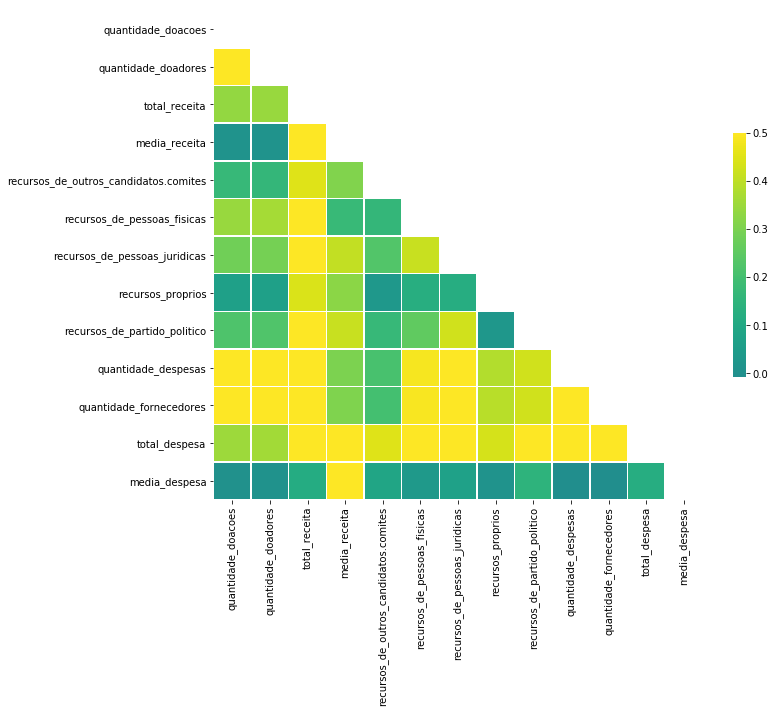

In [88]:
plotCorrelation(data,vm=0.5)

In [89]:
data = data.drop(['recursos_de_outros_candidatos.comites',
           'recursos_de_pessoas_fisicas','recursos_de_pessoas_juridicas',
           'recursos_proprios','partido'
           'quantidade_doadores'],axis=1)

ValueError: labels ['partidoquantidade_doadores'] not contained in axis

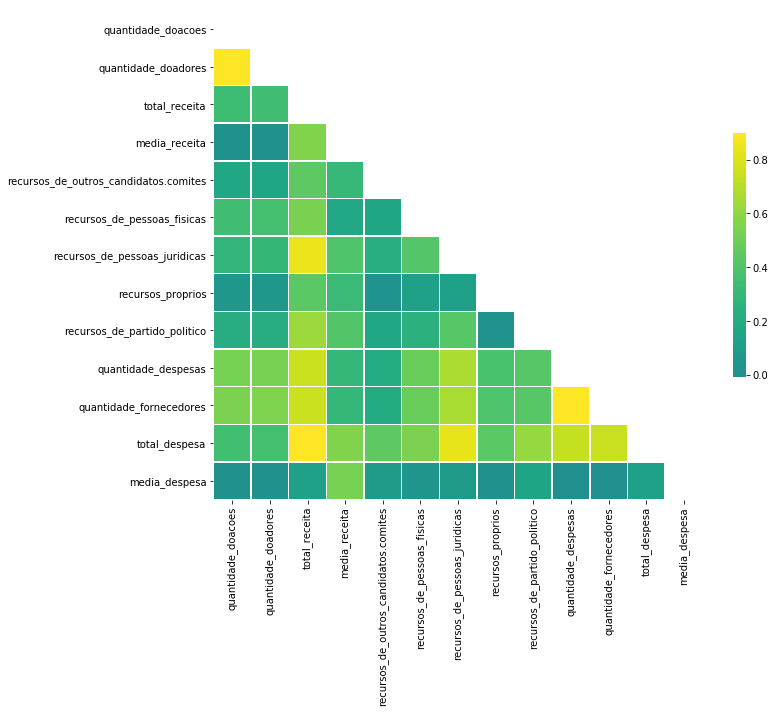

In [90]:
plotCorrelation(data,vm=0.9)

## New feature

In [91]:
N = ['AC','AM','AP','PA','RO','RR','TO']
NE = ['AL','BA','CE','MA','MA','PB','PE','PI','RN']
CO = ['GO','MS','MT']
SE = ['ES','MG','RJ','SP']
S = ['PR','RS','SC']

data['regiao'] = np.where(data['uf'].isin(N+NE),'NNE','SSE')

In [92]:
#dummify
data = data.drop(['uf'],axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7622 entries, 0 to 7621
Data columns (total 17 columns):
partido                                  7622 non-null object
quantidade_doacoes                       7622 non-null int64
quantidade_doadores                      7622 non-null int64
total_receita                            7622 non-null float64
media_receita                            7622 non-null float64
recursos_de_outros_candidatos.comites    7622 non-null float64
recursos_de_pessoas_fisicas              7622 non-null float64
recursos_de_pessoas_juridicas            7622 non-null float64
recursos_proprios                        7622 non-null float64
recursos_de_partido_politico             7622 non-null float64
quantidade_despesas                      7622 non-null int64
quantidade_fornecedores                  7622 non-null int64
total_despesa                            7622 non-null float64
media_despesa                            7622 non-null float64
sexo                

# Explorando os dados

In [93]:
def plot_groups(df):
    ax = df['situacao'].value_counts().plot(kind='bar',
                                              figsize=(10,7))

    ax.set_alpha(0.7)
    ax.set_title("Proporção das classes", fontsize=18)
    ax.set_xlabel("Número de ocorrências no dataset", fontsize=10);
    ax.set_xticklabels(["eleito", "nao_eleito"])

    # create a list to collect the plt.patches data
    totals = []

    # find the values and append to list
    for i in ax.patches:
        totals.append(i.get_height())
    # set individual bar lables using above list
    total = sum(totals)

    # set individual bar lables using above list
    for i in ax.patches:
        # get_x pulls left or right; get_height pushes up or down
        ax.text(i.get_x()+.1, i.get_height()-500, \
                str(round((i.get_height()/total)*100, 2))+'%', fontsize=20,
                    color='white')
        ax.text(i.get_x()+.07, i.get_height()-999, \
                "Total: " + str(i.get_height()), fontsize=18,
                    color='white')

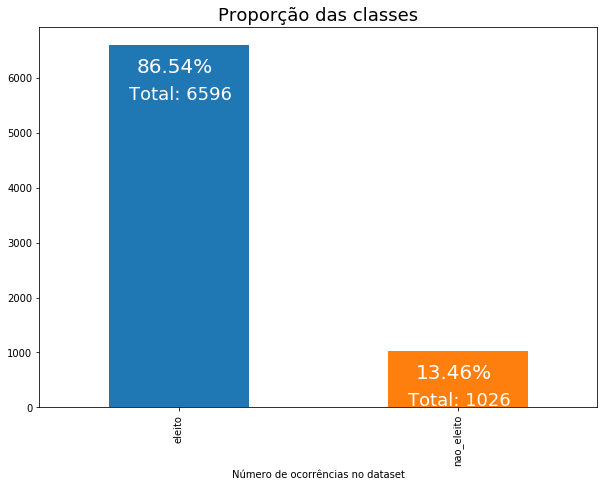

In [94]:
plot_groups(data)

Balanceando as classes

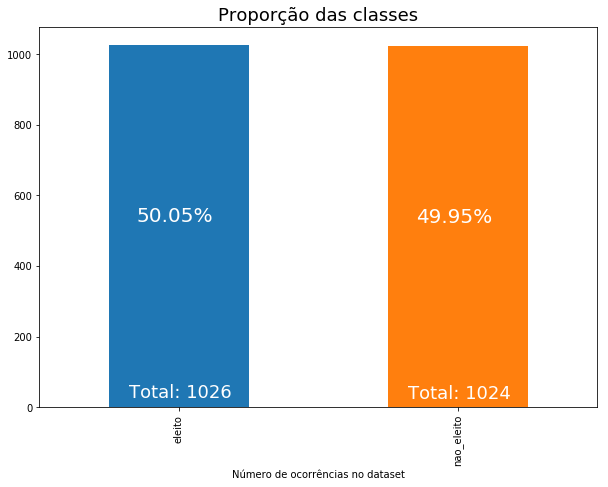

In [95]:
#ressample method
def re_sample(ddf,sample_size=1024):
    dfe = ddf[ddf["situacao"] == "eleito"]
    dfne = ddf[ddf["situacao"] == "nao_eleito"].sample(sample_size)
    
    samples_array = []
    samples_array.append(dfe)
    samples_array.append(dfne)
    
    df = pd.concat(samples_array)
    return df

df = re_sample(data)
plot_groups(df)
#df.shape
#Y = data.pop('situacao')

# Treinamento dos modelos

In [96]:
def arrange_data(ddf):
    ddf['situacao'] = ddf['situacao'].map({'eleito': 1, 'nao_eleito': 0})

    #dados = ddf.drop("situacao", 1)
    y = ddf.pop('situacao')
    
    #dummify
    ddf = pd.get_dummies(ddf)
    train, test, Y_train, Y_test = train_test_split(ddf, y, test_size=0.3) # 70% training and 30% test
    
    return train, test, Y_train, Y_test

train, test, Y_train, Y_test = arrange_data(df)

In [97]:
def f1_score(model,X,Y):
    f1 = cross_val_score(model, X, Y, scoring='f1', cv=10)
    return(f1.mean())

In [98]:
print("X_train: ", train.shape)
print("X_test", test.shape)
print("Y_train", Y_train.shape)
print("Y_test", Y_test.shape)

X_train:  (1435, 48)
X_test (615, 48)
Y_train (1435,)
Y_test (615,)


## Modelos

### Regressão Logistica

In [99]:
lr_model = LogisticRegression(random_state=100)
lr_model.fit(train, Y_train)

lr_model_f1 = f1_score(lr_model,train,Y_train)

print("Train F1: ", lr_model_f1)
print("Test F1: ",lr_model.score(test, Y_test))

Train F1:  0.8569716245963324
Test F1:  0.8682926829268293


### Knn

The optimal number of neighbors is 64


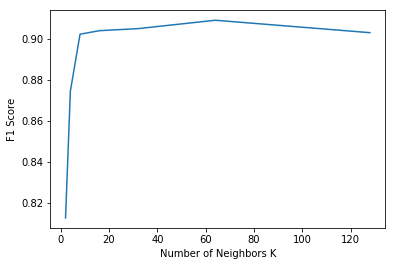

In [100]:
neighbors = [2,4,8,16,32,64,128]

# empty list that will hold cv scores
f1_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    z = f1_score(knn,train,Y_train)
    f1_scores.append(z)

# determining best k
optimal_k = neighbors[f1_scores.index(max(f1_scores))]
print("The optimal number of neighbors is %d" % optimal_k)


plt.plot(neighbors, f1_scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('F1 Score')
plt.show()

In [101]:
knn_model = KNeighborsClassifier(n_neighbors=optimal_k)

knn_model.fit(train, Y_train)
knn_model_f1 = f1_score(knn_model,train,Y_train)
#print(knn_model_f1)
#knn_model.score(X_test, Y_test)

print("Train F1: ", knn_model_f1)
print("Test F1: ",knn_model.score(test, Y_test))

Train F1:  0.9092613562928694
Test F1:  0.9105691056910569


### Arvore de decisão

In [102]:
from sklearn.tree import DecisionTreeClassifier

t_model = DecisionTreeClassifier(random_state=1000)

t_model.fit(train, Y_train)

t_model_f1 = f1_score(t_model,train,Y_train)

print("Train F1: ", t_model_f1)
print("Test F1: ",t_model.score(test, Y_test))

Train F1:  0.8668819251761795
Test F1:  0.8569105691056911


### Adabost

In [103]:
# Create and fit an AdaBoosted decision tree
ab_model = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                         algorithm="SAMME",
                         n_estimators=400)

ab_model.fit(train, Y_train)

ab_model_f1 = f1_score(ab_model,train,Y_train)

print("Train F1: ", ab_model_f1)
print("Test F1: ",ab_model.score(test, Y_test))

Train F1:  0.9050019101206462
Test F1:  0.9073170731707317


### GradientBoosting

In [104]:
gb_model = GradientBoostingClassifier()
gb_model.fit(train, Y_train)

gb_model_f1 = f1_score(gb_model,train,Y_train)

print("Train F1: ", gb_model_f1)
print("Test F1: ",gb_model.score(test, Y_test))

Train F1:  0.899208197974405
Test F1:  0.9008130081300812


## Ensemble

In [105]:
#lr_model, knn_model, t_model, ab_model
from mlxtend.classifier import StackingClassifier
lr = LogisticRegression()
sclf = StackingClassifier(classifiers=[lr_model, knn_model, t_model, ab_model], 
                          meta_classifier=lr)

sclf.fit(train,Y_train)
f1_score(sclf,train,Y_train)
print("Train F1: ", lr_model_f1)
print("Test F1: ",lr_model.score(test, Y_test))

Train F1:  0.8569716245963324
Test F1:  0.8682926829268293


In [106]:
sclf = StackingClassifier(classifiers=[lr_model, knn_model, t_model, ab_model,gb_model],
                          use_probas=True,
                          average_probas=False,
                          meta_classifier=lr)

sclf.fit(train,Y_train)
f1_score(sclf,train,Y_train)
print("Train F1: ", lr_model_f1)
print("Test F1: ",lr_model.score(test, Y_test))

Train F1:  0.8569716245963324
Test F1:  0.8682926829268293


# Dados para o kegle

In [111]:
ktest = pd.read_csv('test.csv', delimiter=',')
idc = ktest.pop('sequencial_candidato')

In [114]:
ktest = ktest.drop(['recursos_de_outros_candidatos.comites','recursos_de_pessoas_fisicas','recursos_de_pessoas_juridicas','recursos_proprios','quantidade_doadores'],axis=1)

ktest = ktest.drop(['nome','cargo','grau','estado_civil','ocupacao','ano','partido'],axis=1)

N = ['AC','AM','AP','PA','RO','RR','TO']
NE = ['AL','BA','CE','MA','MA','PB','PE','PI','RN']
CO = ['GO','MS','MT']
SE = ['ES','MG','RJ','SP']
S = ['PR','RS','SC']

ktest['regiao'] = np.where(ktest['uf'].isin(N+NE),'NNE','SSE')

ktest = ktest.drop(['uf'],axis=1)

KeyError: 'uf'

In [116]:
ktest.info()
data.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4592 entries, 0 to 4591
Data columns (total 10 columns):
quantidade_doacoes              4592 non-null int64
total_receita                   4592 non-null float64
media_receita                   4592 non-null float64
recursos_de_partido_politico    4592 non-null float64
quantidade_despesas             4592 non-null int64
quantidade_fornecedores         4592 non-null int64
total_despesa                   4592 non-null float64
media_despesa                   4592 non-null float64
sexo                            4592 non-null object
regiao                          4592 non-null object
dtypes: float64(5), int64(3), object(2)
memory usage: 358.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7622 entries, 0 to 7621
Data columns (total 17 columns):
partido                                  7622 non-null object
quantidade_doacoes                       7622 non-null int64
quantidade_doadores                      7622 non-null int64
total_

In [117]:
target = gb_model.predict(pd.get_dummies(ktest))

ValueError: Number of features of the model must match the input. Model n_features is 48 and input n_features is 12 

In [ ]:
ddf['situacao'] = ddf['situacao'].map({'eleito': 1, 'nao_eleito': 0})

In [118]:
df.to_csv("sample_2_kegle.csv",index=False)